# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [43]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [44]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 19:57:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  40.9MB/s    in 5.4s    

2021-10-26 19:57:26 (37.1 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [45]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [46]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [47]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = np.sqrt(train_size))
ridge.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, ridge.predict(X_test)) ** 0.5)

9.5101633607661


In [48]:
ridge = Ridge(alpha = 1)
ridge.fit(np.zeros((X_train.shape[0] , 1)), y_train)
print(mean_squared_error(y_test, ridge.predict(np.zeros((X_test.shape[0] , 1)))) ** 0.5)
print(ridge.intercept_)

10.85246390513634
1998.3860949074324


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [49]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [50]:
class HwDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [torch.tensor(self.x[idx, :], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)]

In [51]:
from sklearn.preprocessing import StandardScaler
scallerParam = StandardScaler()
X_train = scallerParam.fit_transform(X_train)
X_test = scallerParam.transform(X_test)

scallerAnsw = StandardScaler()
y_train = scallerAnsw.fit_transform(y_train.reshape(-1, 1))

In [52]:
train_set = HwDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle= True)

In [53]:
test_set = HwDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, drop_last=False)

In [54]:
set_random_seed(0)

model = nn.Sequential(
    nn.Linear(90, 100),
    nn.Dropout(0,25),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Linear(50, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-6)

criterion = nn.MSELoss()

In [55]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader, n_epochs=5):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    val_loses = []
    for epoch in range(n_epochs):
        # тренировка
        model.train()
        k = 0
        for x_train, y_train in train_dataloader:
            y_pred = model(x_train)
            loss = criterion(y_pred.squeeze(),  y_train.data.squeeze())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()

        val_loss = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                y_pred.data *= scallerAnsw.scale_[0]
                y_pred.data += scallerAnsw.mean_[0]
                y_test = y_val * scallerAnsw.scale_[0] + scallerAnsw.mean_[0]
                loss = criterion(y_pred.squeeze(),  y_test.squeeze())
                val_loss.append(loss.numpy())

        print(f"Epoch: {epoch}, loss: {np.mean(val_loss) ** 0.5}")
        val_loses.append(np.mean(val_loss) ** 0.5)
        plt.plot(val_loses)
        plt.show()


def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predicts = torch.tensor(data = [])
    model.eval()
    with torch.no_grad():
                for x_val, y_val in test_loader:
                    y_pred = model(x_val)
                    y_pred *= scallerAnsw.scale_[0]
                    y_pred.data += scallerAnsw.mean_[0]
                    predicts = torch.cat((predicts, y_pred.squeeze()), 0)
    return predicts

Epoch: 0, loss: 8.705031016742065


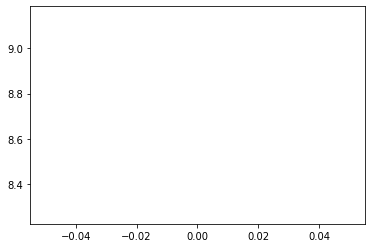

Epoch: 1, loss: 8.601645875504182


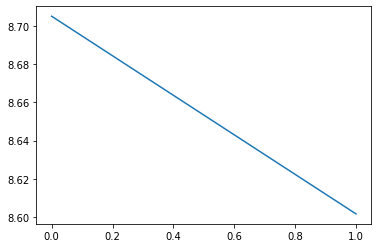

Epoch: 2, loss: 8.573846802866461


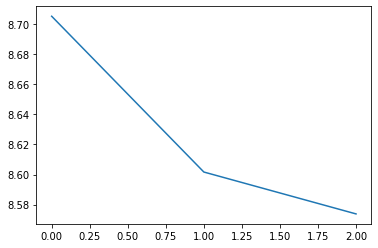

Epoch: 3, loss: 8.520413737392548


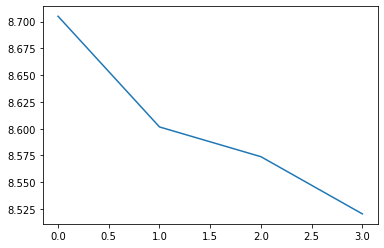

Epoch: 4, loss: 8.456783158889932


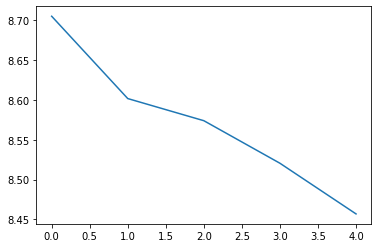

Epoch: 5, loss: 8.450040864563494


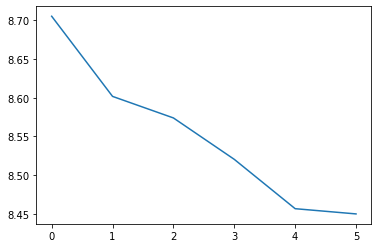

Epoch: 6, loss: 8.40987366353509


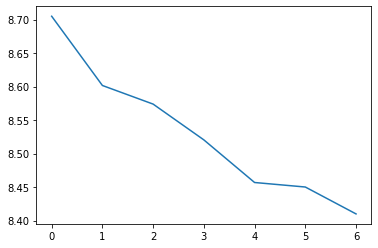

Epoch: 7, loss: 8.380262856378204


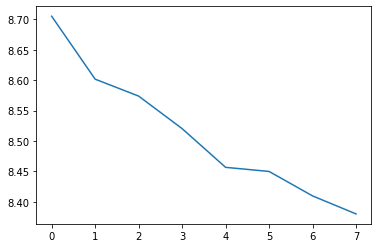

Epoch: 8, loss: 8.356643829537669


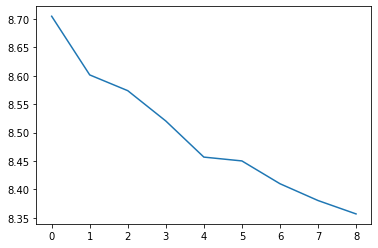

Epoch: 9, loss: 8.355917527540036


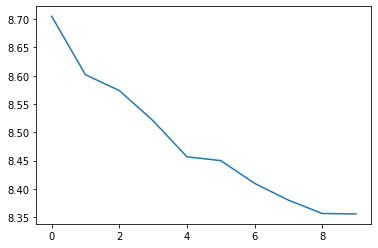

Epoch: 10, loss: 8.352611165452993


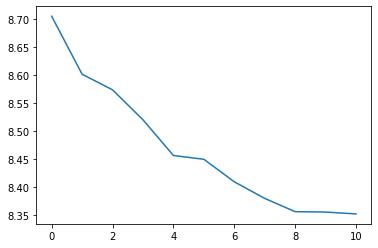

In [56]:
train(model, optimizer, criterion, train_loader, train_loader, 11)

In [57]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]
predicts = test(model, criterion, test_loader)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(predicts.numpy(), y_test) ** 0.5)

8.734531720392727


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

При выборе модели я опирался на то, что всего в traget переменной было 90 летний разброс, поэтому в первом скрытомслое должно было быть от 90 нейронов, я взял 100 и постепенно уменьшал( была еще подсказка в чате про ширину в 100 нейронов). Также я выбрал 3 слоя в модели, так как при меньшем модель переобучалась, а при большем переобучалась (также была подсказка 24 числа). В основном самым большим недочетом в обучении было несоответствие в размерности тензоров предскзания модели и таргет переменной из-за этого модель не могла обучиться, на обнаружение данной ошибки я потрати 3 ПРЕКРАСНЫХ дня. Далее не сразу понял, что на обучении модель нужно переводить в состояние обучения model.train() и выводить из этого состояния model.eval(). В состоянии обучения Dropout и Batchnorm не работали корректно. Из-за двух вышеперечисленныз ошибок была потрачена неделя просто так, модель не опускалась ниже 11 RMSE на обучающей выборке. Очень помогло отмасштабировать данные, при этом RMSE упало от 10,5 до 9, но данный метод нуждается в особом обучении: я пробовал домножать loss на scale и превращать target в обычный год, но тогда эти объекты теряли оптимизатор и функцию ошибки. Поэтому я пришел к тому виду обучения, который описан в методе.

Для реализации данной модели были необходимо преминение BatchNorm1d между всеми слоями (так как он улучшает поверхность loss функции) и Dropout между входным и первым скрытым слоем слоем:
1. При большом количестве Dropout модель не могла обучиться. При вставке еще одного Dropout(0.2) между первым и вторым скрытыми слоями моедель показывала худшее качество RMSE на 11 эпохе равное 8.76657166677476, что на 0,03 хуже показанного. Поэтому я ограничился на одном Dropout. Видимо модель не могла найти закономерности при отключении большого количества связей между слоями. На 11 эпохах 2 Dropout показывал на обучающей выборке немного худшее качество:<br />
Epoch: 0, loss: 8.780803845566556<br />
Epoch: 1, loss: 8.741649894104302<br />
Epoch: 2, loss: 8.670959974247372<br />
Epoch: 3, loss: 8.651794388598132<br />
Epoch: 4, loss: 8.628503502512535<br />
Epoch: 5, loss: 8.59887719919956<br />
Epoch: 6, loss: 8.594758463556436<br />
Epoch: 7, loss: 8.563777633352913<br />
Epoch: 8, loss: 8.572476777061675<br />
Epoch: 9, loss: 8.539533345607486<br />
Epoch: 10, loss: 8.528700003803793<br /> 

2. Необходимо было подобрать параметр для Dropout: при стандартном 0,5 качество модели очень ухудшалось, градиент на обучающей выборке не падал постепенно, модель не могла уловить зависимость в данных:<br />
Epoch: 0, loss: 9.033504851379798<br />
Epoch: 1, loss: 8.9867426397959<br />
Epoch: 2, loss: 8.978212900392016<br />
Epoch: 3, loss: 8.984313858487608<br />
Epoch: 4, loss: 8.875444857771347<br />
Epoch: 5, loss: 8.81285624764748<br />
Epoch: 6, loss: 8.84778947540425<br />
Epoch: 7, loss: 8.878500234750069<br />
Epoch: 8, loss: 8.753822145819763<br />
При выборе Dropout(0,25) модель быстро доходила до 8 эпохо, где ее loss падал, на 9 он начинал рости:<br />
Epoch: 0, loss: 8.70302374899025<br />
Epoch: 1, loss: 8.599026256703521<br />
Epoch: 2, loss: 8.576390937121959<br />
Epoch: 3, loss: 8.528476362024882<br />
Epoch: 4, loss: 8.46345923437421<br />
Epoch: 5, loss: 8.448580325799382<br />
Epoch: 6, loss: 8.414134585781042<br />
Epoch: 7, loss: 8.378322113233978<br />
Epoch: 8, loss: 8.350824335946946<br />
Epoch: 9, loss: 8.357908658629627<br />

Выбрать пришлось поменьше Dropout(0,2).

3. Также к данной модель пробовал применить weight_decay, но все попытки были тчетны. Обучение резко замедлялось. При большом значении weight_decay = 1e-3 loss вел себя странно, он  был в окрестности 8,7:<br />
Epoch: 0, loss: 8.770505148455364<br />
Epoch: 1, loss: 8.702872089430045<br />
Epoch: 2, loss: 8.71377782659338<br />
Epoch: 3, loss: 8.710413293504066<br />
При значениях меньше weight_decay = 1e-6: <br />
Epoch: 0, loss: 8.705031016742065<br />
Epoch: 1, loss: 8.601645875504182<br />
Epoch: 2, loss: 8.573846802866461<br />
Epoch: 3, loss: 8.520413737392548<br />
Epoch: 4, loss: 8.456783158889932<br />
Epoch: 5, loss: 8.450040864563494<br />
Epoch: 6, loss: 8.40987366353509<br />
Epoch: 7, loss: 8.380262856378204<br />
Epoch: 8, loss: 8.356643829537669<br />
Epoch: 9, loss: 8.355917527540036<br />
Epoch: 10, loss: 8.352611165452993<br />

Без weight_decay = 1e-6 RMSE на тестовой выборке 8.75430983393635, с ним же 8.734531720392727, при использовании удалось улучшить результат на 0,2.

